In [74]:
from tqdm import tqdm_notebook
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import umap
import os
from scipy.spatial.distance import pdist, cdist, squareform, euclidean
from sklearn.cluster import DBSCAN, MeanShift
from sklearn.metrics import silhouette_score, \
                            davies_bouldin_score, \
                            pairwise_distances, \
                            confusion_matrix, \
                            f1_score, \
                            accuracy_score, \
                            make_scorer, \
                            calinski_harabasz_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors, KernelDensity
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap
from sklearn.datasets import make_blobs, make_moons, make_circles
# %matplotlib notebook
import matplotlib.pyplot as plt
from itertools import combinations
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import Axes3D 
import multiprocessing
from joblib import Parallel, delayed
from utils import filter_paths, NPR, clustering, unpack_data, nearest_ratio_score, get_neigh_perc, plot_clustering
np.random.seed(42)
from lightgbm import LGBMClassifier

In [115]:
def nearest_ratio_score(X,y, k=5):
    X_pd = squareform(pdist(X))
    s = []
    s_min = []
    for y_i in np.unique(y):
        mask = y==y_i
        nearest_mates = np.sort(X_pd[mask,:][:,mask], axis=1)[:,1:k+1].mean(1)
        nearest_foes = np.sort(X_pd[mask,:][:,~mask], axis=1)[:,1:k+1].mean(1)

    #     y_i_diam = X_pd[mask,:][:,mask].min() + 1e-5
    #     y_ij_r = X_pd[mask,:][:,~mask].max() + 1e-5

    #     s_min.append(y_ij_r/y_i_diam)

        s.append((nearest_mates/nearest_foes).mean())
    return np.mean(s)# / max(s_min)

In [116]:
# X,y = data_dict['moons']
# nn = NearestNeighbors(n_neighbors=5)
# nn.fit(X)
# neigh_dist, neigh_ind = nn.kneighbors(X)
# s = []
# y1,y2 = [0,1]
# dist_C0 = neigh_dist[:,1:][y==y1].min(1)
# dist_C1 = neigh_dist[:,1:][y==y2].min(1)
# cdist_C = cdist(X[y==y1], X[y==y2])
# cdist_C0 = cdist_C.min(axis=1)
# cdist_C1 = cdist_C.min(axis=0)
# s0 = (dist_C0/cdist_C0).mean()
# s1 = (dist_C1/cdist_C1).mean()
# s.append((s0 + s1)/2)

# Toy example

In [117]:
# def nearest_ratio_score(X,y, n_neighbors=5): 
#     nn = NearestNeighbors(n_neighbors=n_neighbors)
#     nn.fit(X)
#     neigh_dist, neigh_ind = nn.kneighbors(X)
#     s = []
#     for y1,y2 in list(combinations(np.unique(y),2)):
#         # take two different clusters
#         dist_C0 = neigh_dist[:,1:][y==y1].min(1) # расстояние до ближайшей из своего кластера
#         dist_C1 = neigh_dist[:,1:][y==y2].min(1) # расстояние до ближайшей из своего кластера
    
#         cdist_C = cdist(X[y==y1],X[y==y2])
#         cdist_C0 = cdist_C.min(axis=1) # расстояние до ближайшей из чужого кластера
#         cdist_C1 = cdist_C.min(axis=0) # расстояние до ближайшей из чужого кластера
#         s0 = (dist_C0/cdist_C0).mean()
#         s1 = (dist_C1/cdist_C1).mean()
#         s.append((s0 + s1)/2)
#     return np.mean(s)

In [168]:
# Davies Bouldin Index
def DB_index_G(X, labels, G, n_cl=None):

    if -1 in labels:
        X = X[labels != -1]
        labels = labels[labels != -1]
    
    n_clusters = len(np.unique(labels))
    N = X.shape[0]
        
    # cluster_medoids
    clusters_centers = np.zeros((n_clusters,), dtype=int)
    mean_k_dist = np.zeros((n_clusters,))
    for i,k in enumerate(np.unique(labels)):
        mask = labels==k
        arguments = np.arange(N)[mask]
        k_medoid = arguments[G[mask,:][:,mask].sum(1).argmin()]

        clusters_centers[i] = int(k_medoid)
        mean_k_dist[i] = G[mask][:,k_medoid].mean()
    
    db = 0
    for i in range(n_clusters):
        db_max = []
        for j in range(n_clusters):
            if j!=i:
                db_max.append((mean_k_dist[i] + mean_k_dist[j]) / G[clusters_centers[i],clusters_centers[j]])
        db += max(db_max)
        
    return db / n_clusters

In [131]:
X,labels = make_blobs(n_samples=1000, random_state=8) # data_dict['uniform']  # make_circles(n_samples=1000, factor=.5,noise=.05) #
# nn = NearestNeighbors(n_neighbors=10) 
# nn.fit(X)
# neigh_dist, neigh_ind = nn.kneighbors(X)

In [167]:
# if -1 in labels:
#     X = X[labels != -1]
#     labels = labels[labels != -1]

# n_clusters = len(np.unique(labels))
# N = X.shape[0]

# ismp = Isomap(n_components=2)
# ismp.fit(X)
# X_iso = ismp.dist_matrix_

# # cluster_medoids
# clusters_centers = np.zeros((n_clusters,), dtype=int)
# mean_k_dist = np.zeros((n_clusters,))
# for i,k in enumerate(np.unique(labels)):
#     mask = labels==k
#     arguments = np.arange(N)[mask]
#     k_medoid = arguments[X_iso[mask,:][:,mask].sum(1).argmin()]

#     clusters_centers[i] = int(k_medoid)
#     mean_k_dist[i] = X_iso[mask][:,k_medoid].mean()

# db = 0
# for i in range(n_clusters):
#     db_max = []
#     for j in range(n_clusters):
#         if j!=i:
#             db_max.append((mean_k_dist[i] + mean_k_dist[j]) / X_iso[clusters_centers[i],clusters_centers[j]])
#             print(X_iso[clusters_centers[i],clusters_centers[j]])
#     db += max(db_max)
    
# db/n_clusters

0.0
0.0
0.0
0.0
0.0
0.0


inf

In [166]:
# plt.scatter(X[:,0], X[:,1], c=labels)
# for c_k in clusters_centers:
#     plt.scatter(X[c_k,0], X[c_k,1], marker='*')

In [164]:
np.random.seed(0)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500

data_dict = {'circles': make_circles(n_samples=n_samples, factor=.5,noise=.05),
             'moons': make_moons(n_samples=n_samples, noise=.05),
             'blobs': make_blobs(n_samples=n_samples, random_state=8)}

no_structure = np.random.rand(n_samples, 2)
y_no_structure = (no_structure[:,0] > no_structure.mean()).astype(int)
y_random = np.random.randint(0,2, size=n_samples)
data_dict['uniform'] = [no_structure, y_no_structure]
data_dict['random'] = [no_structure, y_random]

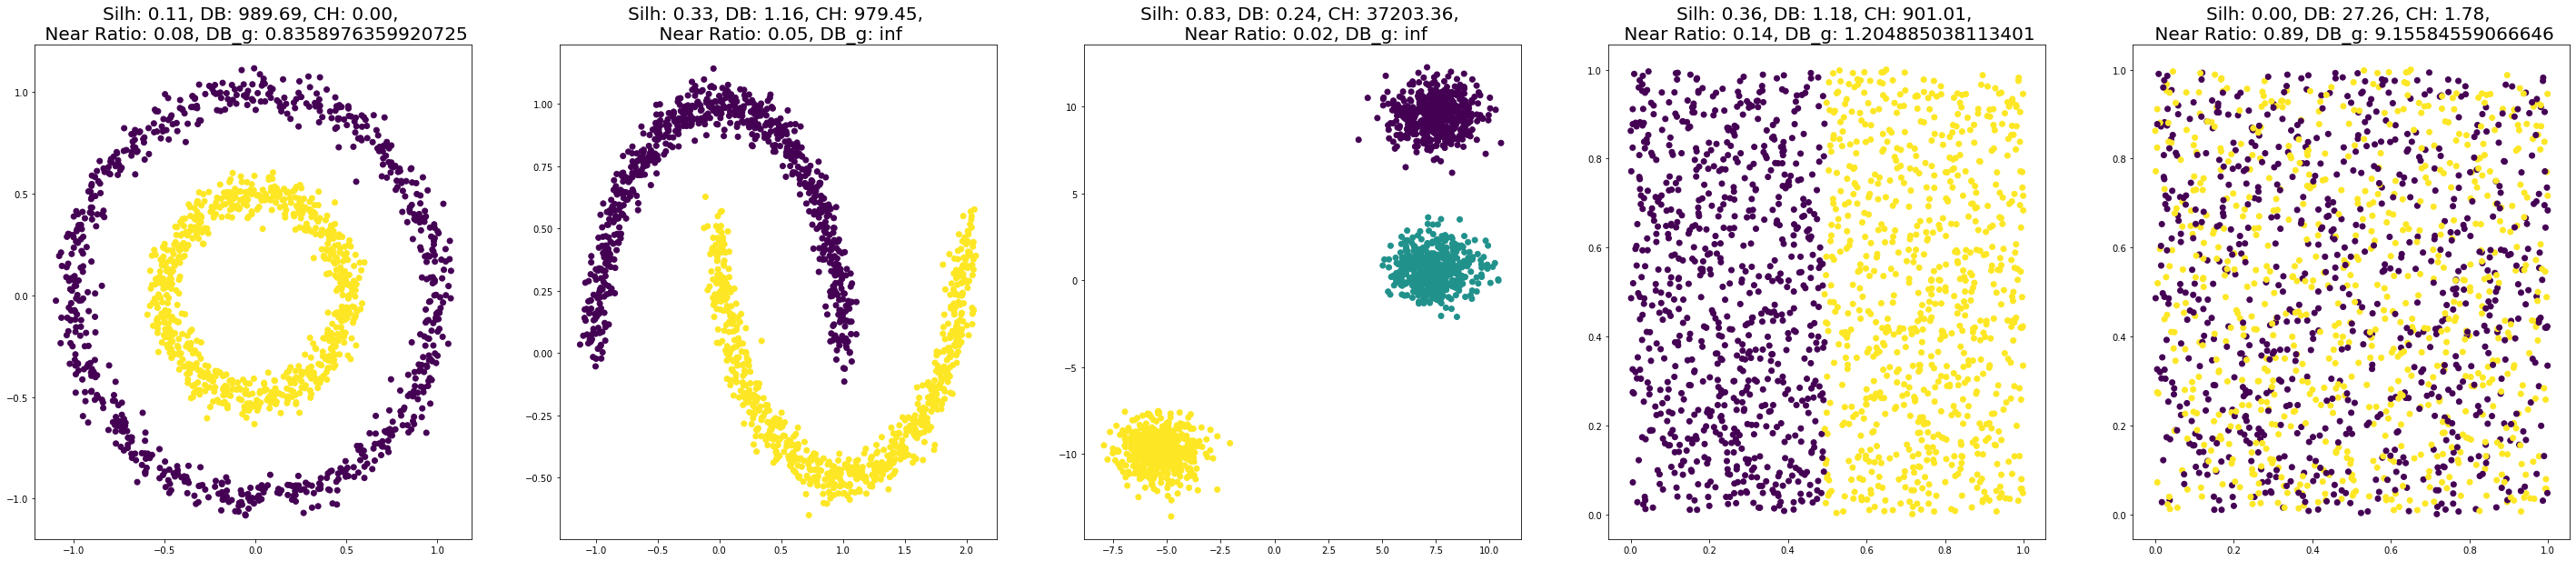

In [165]:
fig, axes = plt.subplots(ncols=len(data_dict), figsize=(len(data_dict)*10, 10))
for i,(k,v) in enumerate(data_dict.items()):
    x,y = v
    db = davies_bouldin_score(x,y)
    dbg = DB_index_G(x,y)
    sh = silhouette_score(x,y)
    ch = calinski_harabasz_score(x,y)
    nr = nearest_ratio_score(x,y)
    
    sh = "{:.2f}".format(sh)
    db = "{:.2f}".format(db)
    ch = "{:.2f}".format(ch)
    nr = "{:.2f}".format(nr)
    
    axes[i].scatter(x[:,0], x[:,1], c=y)
    axes[i].set_title(f'Silh: {sh}, DB: {db}, CH: {ch}, \n Near Ratio: {nr}, DB_g: {dbg}', fontsize=20)
plt.show()

In [10]:
data = {}
for k,v in data_dict.items():
    data[k] = v[0]

In [13]:
LABEL2DBSCAN_PARAMS = {}
for label,d in data.items():
    p95_list = get_neigh_perc(d)
    LABEL2DBSCAN_PARAMS[label] = [min(p95_list), max(p95_list)]

In [29]:
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
from copy import copy

RANDOM_SEED=42
FIGSIZE=(5,5)
DPI=150
FONTSIZE=12

SILHOETTE_THRESHOLD_DISTINCT = 0.5
SILHOETTE_THRESHOLD_MODERATE = 0.85
DB_THRESHOLD_DISTINCT = 0.4
DB_THRESHOLD_MODERATE = 0.8

In [34]:
def plot_proj_clustering(clustering_results, method='', suptitle=None, data_default_metrics=None):
    '''
    clustering_results - dict
    '''
    results = copy(clustering_results)
    L = len(clustering_results)
    
    for label,data in results.items():
        if len(data) > 0:
            plt.figure(figsize=FIGSIZE, dpi=DPI)
            df = pd.DataFrame(data=data).T
            df.columns = ['Davies-Bouldin index', 'Silhouette score', 'Noise Ratio', 'Normalized Entropy'] # , 'NN Ratio Score'
#             df.drop('NN Ratio Score', axis=1, inplace=True)
            df.sort_index(ascending=False, inplace=True)
#             colors = ['blue', 'orange', 'green', 'red', 'purple']
            colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] # , 'tab:purple'

            if df['Noise Ratio'].sum() == 0.:
                df.drop('Noise Ratio', axis=1, inplace=True)
                colors = ['tab:blue', 'tab:orange', 'tab:red'] # , 'tab:purple'
            plt.xlabel('# estimated clusters', fontsize=FONTSIZE)
#             dataset, _, tax = label.split('_'); tax = tax.capitalize()
#             if dataset == 'ptb':
#                 dataset = 'HMP'
#             label = f'Dataset: {dataset}, Tax: {tax}'
#             label = label + '\n' + method if len(method) > 0 else label
            plt.title(suptitle + ', ' + label if suptitle is not None else label, fontsize=FONTSIZE)
# #             plt.plot(df.index.to_list(), [DB_THRESHOLD_DISTINCT]*df.shape[0], linestyle='--', color='blue')
            plt.hlines(DB_THRESHOLD_DISTINCT, -1, max(df.index), linestyle='--', color='blue', alpha=0.5, label='DB index threshold')
            plt.hlines(SILHOETTE_THRESHOLD_DISTINCT, -1, max(df.index), linestyle='--', color='orange', alpha=0.5, label='Silhoette score threshold')
            plt.legend(fontsize=6)
            df.plot.bar(ax=plt.gca(), color=colors)

            if data_default_metrics is not None:
                def_clust_type, Silhoette_default = data_default_metrics[label]
    #                         if not DB_default > 1.5*max(df['Davies-Bouldin index']):
    #                             ax.hlines(DB_default, 0, len(df.index), linestyles='dotted', colors='blue')
                ax.hlines(Silhoette_default, 0, len(df.index), linestyles='dotted', colors='orange', label=def_clust_type)
                ax.legend(fontsize=6)
            plt.show()

In [23]:
methods_dict = {'dbscan':[DBSCAN, [None]*15],
               'KMeans':[KMeans, np.arange(2, 10, 1)],
               'SpectralClustering':[SpectralClustering, np.arange(2, 10, 1)]}

methods_names = list(methods_dict.keys())

cluster_results_list = []
cluster_preds_list = []

for method_name in tqdm_notebook(methods_names):
    method_class, param_range = methods_dict[method_name]
    cluster_results, cluster_preds = clustering(data, 
                                                method_class, 
                                                param_range, 
                                                dbscan=method_name=='dbscan', 
                                                dbscan_params_dict=LABEL2DBSCAN_PARAMS)
    
    cluster_results_list.append(cluster_results)
    cluster_preds_list.append(cluster_preds)

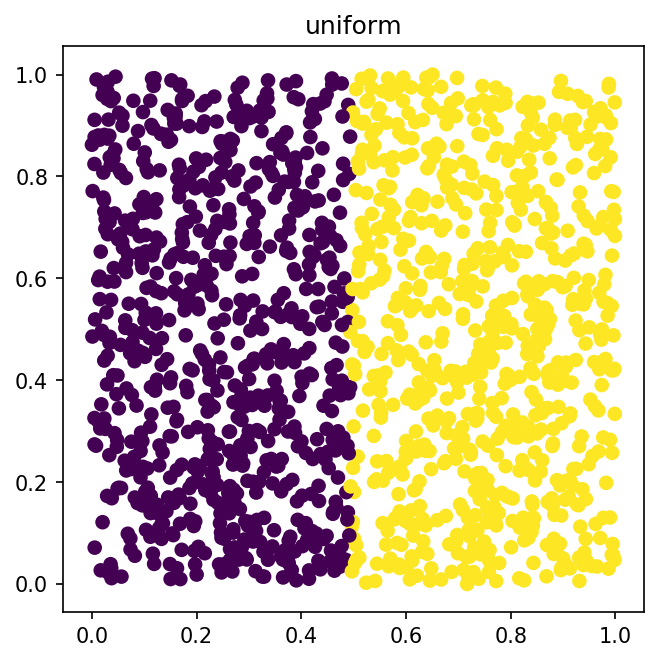

In [44]:
x,y = data_dict['uniform']
plt.figure(figsize=FIGSIZE, dpi=DPI)
plt.scatter(x[:,0], x[:,1], c = y)
plt.title('uniform', fontsize=FONTSIZE)
plt.show()

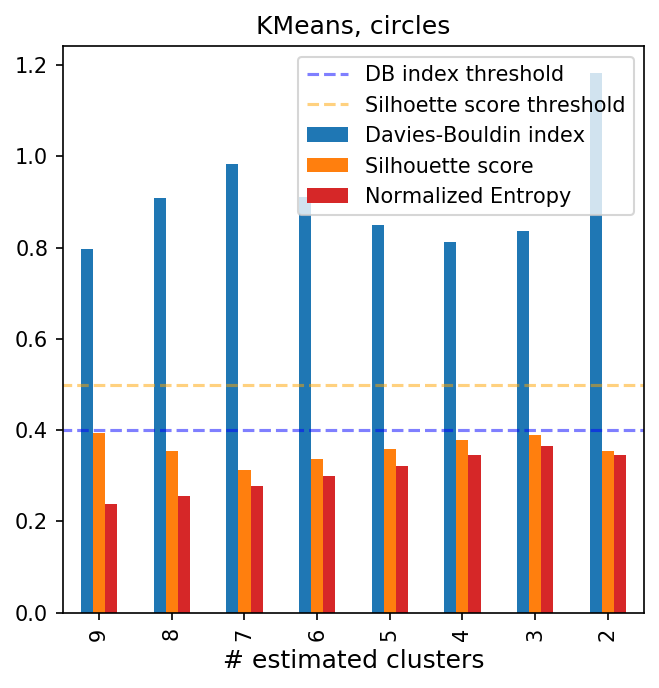

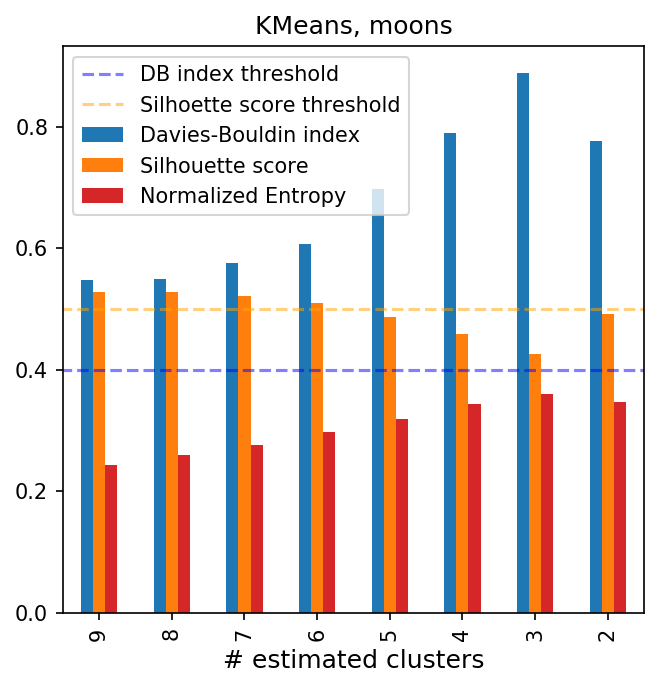

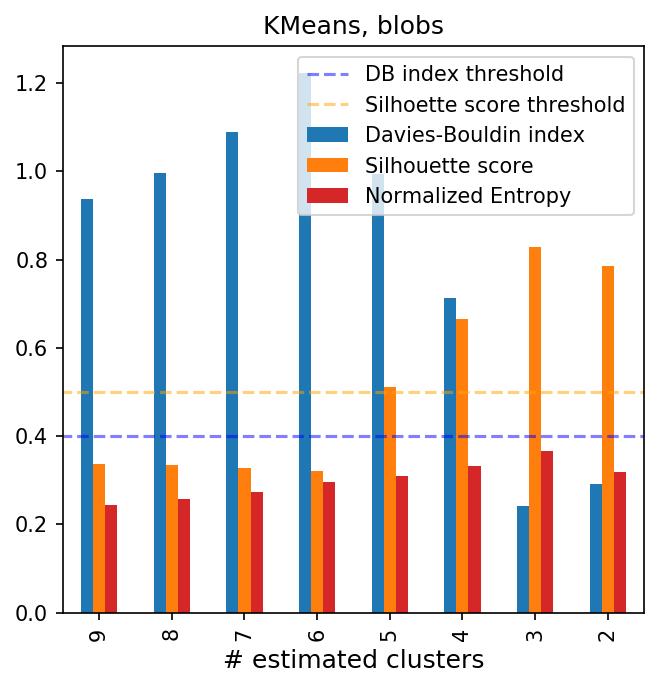

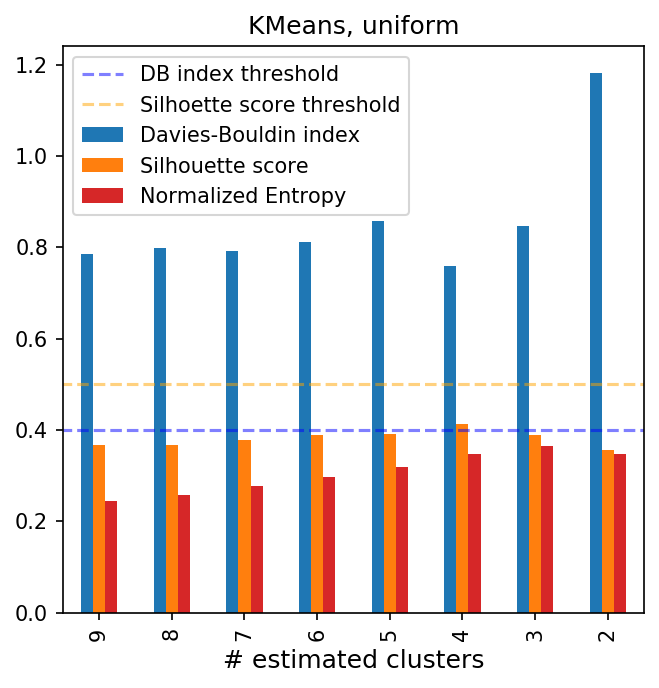

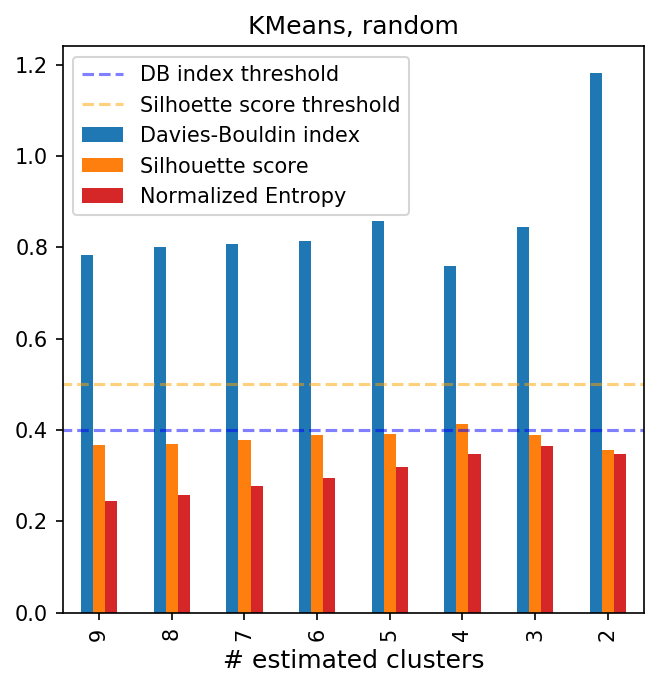

In [37]:
plot_proj_clustering(cluster_results_list[1], method='pca', suptitle='KMeans')

# Generate data

In [2]:
# paths to the databases containing the PCA and Isomap projections 
root = './separate_datasets_transformed/'
root_pca = './separate_datasets_proj/'
DATASETS = ['AGP_proj_o', 'ptb_proj_o']
N_DATASETS = len(DATASETS)

paths = filter_paths([os.path.join(root,path) for path in os.listdir(root)], keywords=DATASETS)
paths_pca = filter_paths([os.path.join(root_pca,path) for path in os.listdir(root_pca)], keywords=DATASETS)
paths_mf_lle = filter_paths(paths, keywords=['lle'])
paths_mf_isomap = filter_paths(paths, keywords=['isomap'])

In [3]:
data_pca = unpack_data(paths_pca)
data_lle = unpack_data(paths_mf_lle)
data_isomap = unpack_data(paths_mf_isomap)

In [4]:
# X,y = data_pca['ibd_proj_o'], None
# X,y = make_blobs(n_samples=1000, n_features=2, centers=np.array([[5,5],[-5,5], [0,-5]]))
# plt.scatter(X[:,0],X[:,1], c=y)
# plt.show()

In [5]:
X = data_isomap['AGP_proj_o']

# Estimate distribution

In [180]:
p95_list = get_neigh_perc(X)
DBSCAN_PARAMS = [min(p95_list), max(p95_list)]

In [181]:
eps = np.mean(DBSCAN_PARAMS)

In [192]:
DBSCAN_PARAMS

[0.06636415641348863, 0.127389576089063]

In [197]:
X_sample = kde.sample(n_samples=1000, random_state=42)

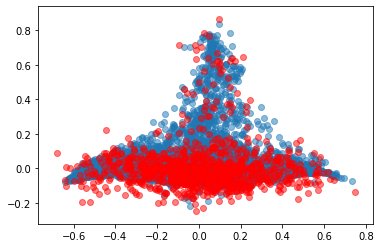

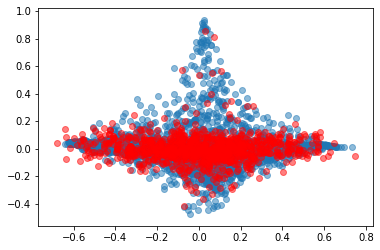

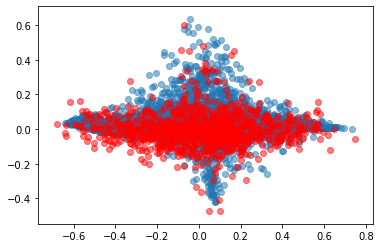

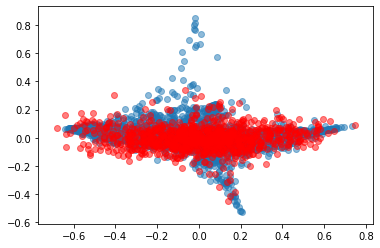

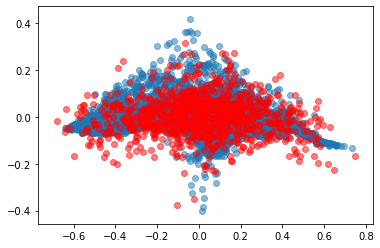

In [198]:
for i,j in list(combinations(range(d),2))[:5]:
    plt.show()
    plt.scatter(X[:,i],X[:,j], alpha=0.5)
    plt.scatter(X_sample[:,i],X_sample[:,j], color='r', alpha=0.5)
    plt.show()

# Spurious clusters visualization

In [6]:
root_sep_trans = './separate_datasets_transformed/'
paths_tsne_separate = [os.path.join(root_sep_trans, path) for path in os.listdir(root_sep_trans)]
name = 'AGP_proj_o_tsne'
paths_tsne_separate = list(filter(lambda x: name in x.split('/')[-1].split('.')[0], paths_tsne_separate))
data_transformed3d_merged = { p.split('/')[-1].split('.')[0]:np.load(p, allow_pickle=True) for p in paths_tsne_separate}
X_tsne = data_transformed3d_merged[name]

In [7]:
tsne_p95_list = get_neigh_perc(X_tsne)
TSNE_DBSCAN_PARAMS = [min(tsne_p95_list), max(tsne_p95_list)]

In [8]:
TSNE_DBSCAN_PARAMS

[0.8213195265697741, 1.9196755368892475]

In [31]:
# sort_index_z = np.argsort(X_tsne[:,2])
# sort_index_y = np.argsort(X_tsne[:,1])
# wicked_index = np.concatenate([sort_index_z[:400], sort_index_y[2000:2200], sort_index_z[-300:]])

z_upper_mask = (X_tsne[:,2] < 20) * (X_tsne[:,2] > 15)
z_lower_mask = (X_tsne[:,2] > -5) * (X_tsne[:,2] < 10) * (X_tsne[:,0] < -10) * (X_tsne[:,1] < -10)
z_mean_mask = (X_tsne[:,2] < -2) * (X_tsne[:,0] > 5) * (X_tsne[:,1] > 5) * (X_tsne[:,2] > -6)

mask = (z_upper_mask + z_lower_mask + z_mean_mask).astype(bool)

X_tsne_chosen = X_tsne[mask]

In [32]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.8).fit(X_tsne_chosen)
X_tsne_sample = kde.sample(n_samples=100, random_state=42)

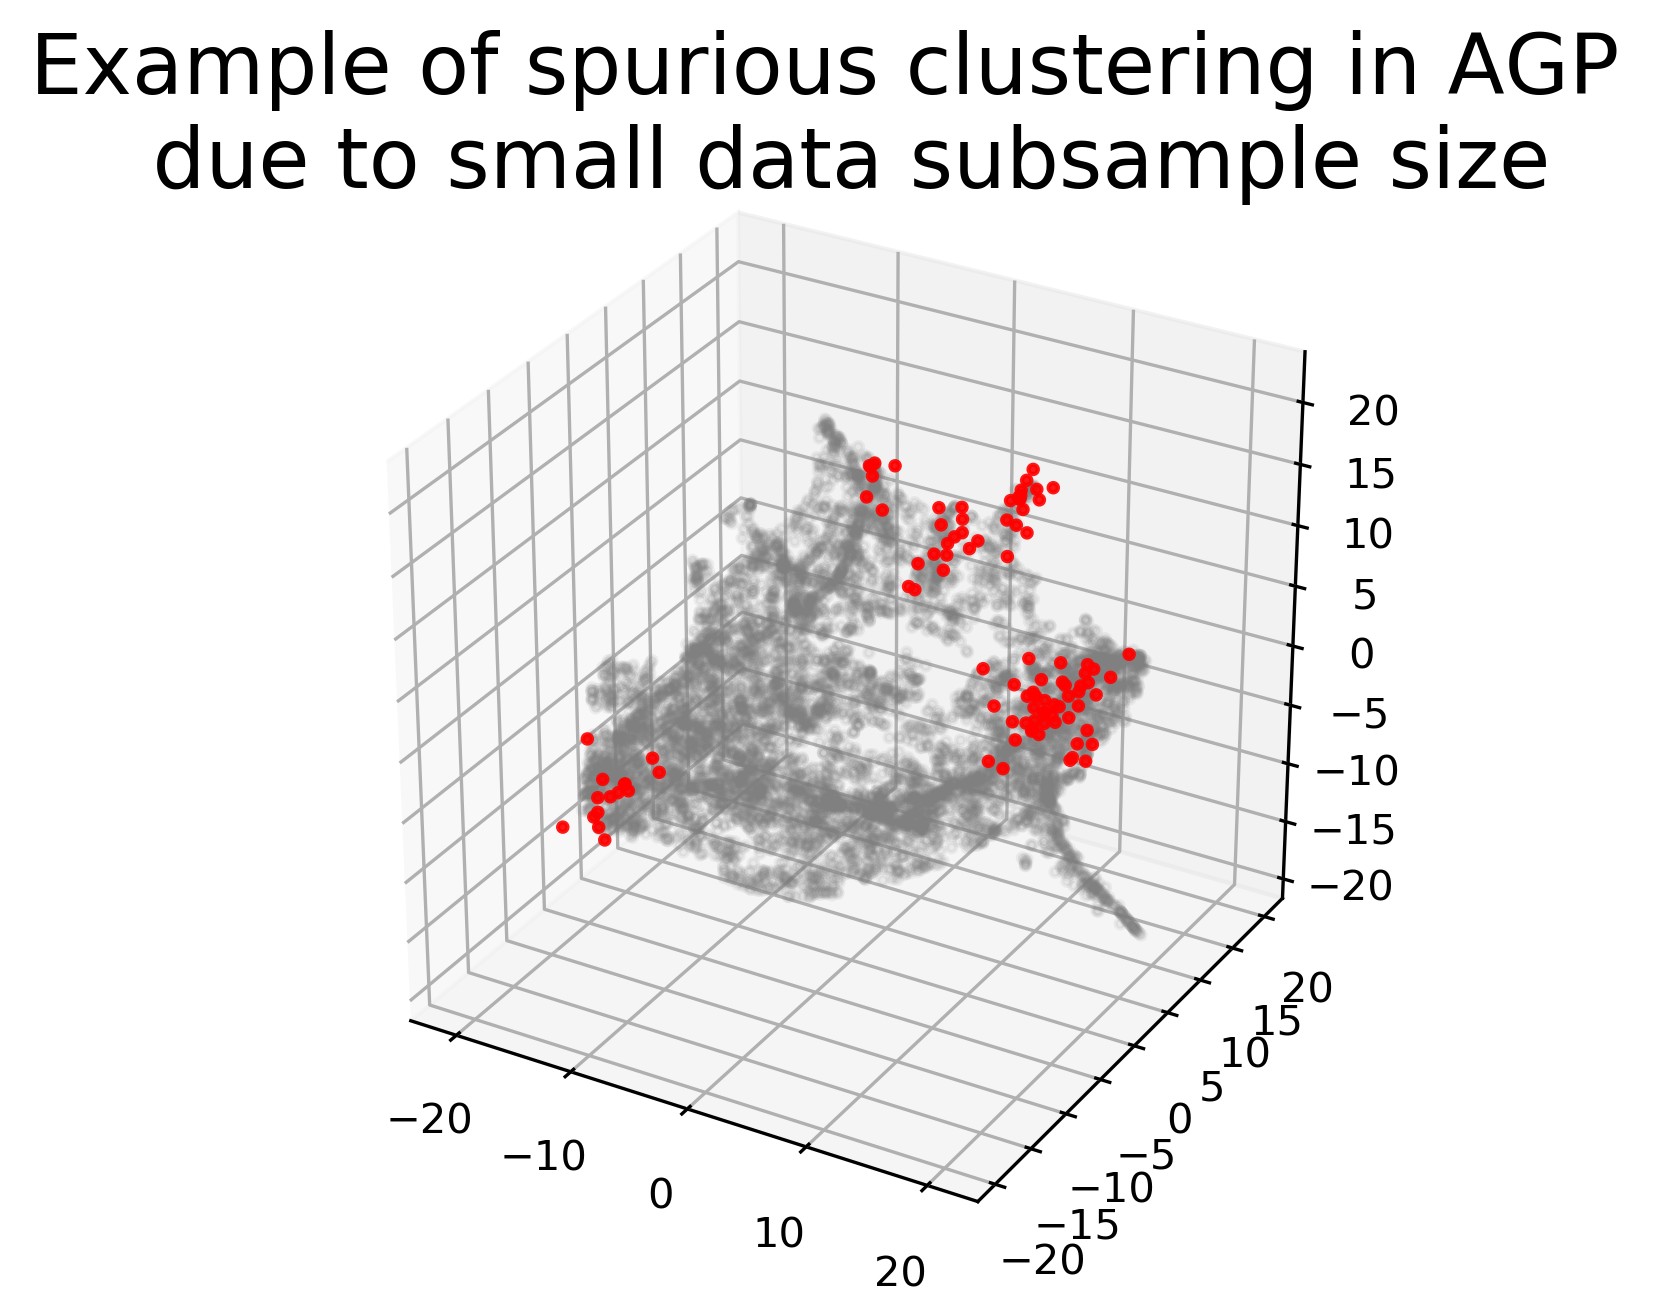

In [33]:
fig = plt.figure(figsize=(5,5), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(X_tsne[:,0], X_tsne[:,1], X_tsne[:,2], marker='.', color='gray', alpha=0.1)
ax.scatter(X_tsne_sample[:,0], X_tsne_sample[:,1], X_tsne_sample[:,2], marker='.', color='r', alpha=0.9)
ax.set_title(f'Example of spurious clustering in AGP \n due to small data subsample size', fontsize=20, pad=10)
    
#     handles, labels = scatter.legend_elements(alpha=0.8)
#     plt.legend(handles, labels, loc="upper right")
# lgnd = plt.legend() 
# for lm in lgnd.legendHandles:
#     lm.set_alpha(0.9)
plt.show()

# Number of clusters distribution

In [199]:
def make_best_prediction(method, X, param_range):
    best_silh = -np.inf
    best_pred = 1
    for param in param_range:
        m = method(eps=param, n_jobs=-1)
        pred = m.fit_predict(X)
        n_clust = len(np.unique(pred[pred != -1]))
        if n_clust > 1:
            silh = silhouette_score(X, pred)
        else:
            silh = -np.inf
        if silh > best_silh:
            best_silh = silh
            best_pred = n_clust
        
    return best_pred

In [200]:
sample_times = 50
results = {}
sample_size_range = np.arange(50,N//2,100)
param_range = np.linspace(*DBSCAN_PARAMS,num=5)

for sample_size in tqdm_notebook(sample_size_range):
    metrics = defaultdict(list)
    for i in range(sample_times):
        samples = kde.sample(n_samples=sample_size)
        best_pred = make_best_prediction(DBSCAN, samples, param_range)
#         metrics['samples'].append(samples)
#         metrics['preds'].append(pred)
#         if best_m is not None:
        metrics['n_clust'].append(best_pred)
#         metrics['noise_ratio'].append(sum(pred == -1)/len(pred))
    results[sample_size] = metrics

In [201]:
# for k,r in results.items():
#     plt.figure()
#     plt.title(k)
#     plt.hist(r['n_clust'])
#     plt.show()

In [204]:
def entropy(x, support=None):
#     bins = len(np.unique(x))
    pdf = np.histogram(x, bins=np.concatenate([support, [max(support)+1]]), density=True, range=(min(support), max(support)))[0]
    H = -np.sum(pdf*np.log(pdf+1e-5))
    return H

clusters = np.array([r['n_clust'] for r in results.values()])
support = np.unique(clusters.flatten())
clusters_H = [entropy(r['n_clust'], support) for r in results.values()]

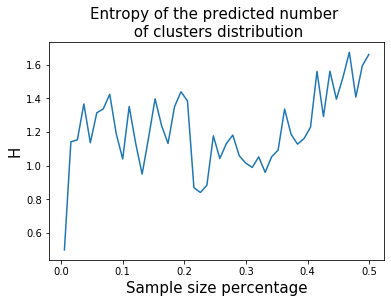

In [205]:
plt.plot(sample_size_range/N, clusters_H)
plt.title('Entropy of the predicted number \n of clusters distribution', fontsize=FONTSIZE)
plt.xlabel('Sample size percentage', fontsize=FONTSIZE)
plt.ylabel('H', fontsize=FONTSIZE)
plt.show()

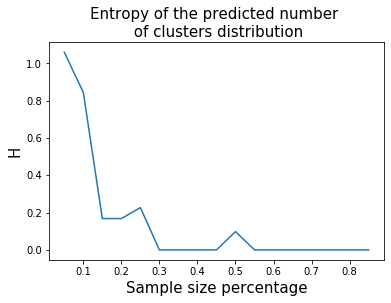

In [170]:
# plt.plot(sample_size_range/N, clusters_H)
# plt.title('Entropy of the predicted number \n of clusters distribution', fontsize=FONTSIZE)
# plt.xlabel('Sample size percentage', fontsize=FONTSIZE)
# plt.ylabel('H', fontsize=FONTSIZE)
# plt.show()

# Silhoette\DB-index distribution

In [68]:
# sample_times = 50
# results = []
# preds = []
# for i in tqdm_notebook(range(sample_times)):
#     samples = kde.sample(n_samples=100, random_state=i)

#     cluster_results, cluster_preds = clustering({'data':X}, 
#                                                 KMeans, 
#                                                 np.arange(2, 10, 1), 
#                                                 dbscan=False, 
#                                                 dbscan_params_dict=None)
#     results.append(cluster_results)
#     preds.append(cluster_preds)
# clear_output()

In [69]:
results_dbind = np.array([[v[0] for k,v in r['data'].items()] for r in results])
results_silh = np.array([[v[1] for k,v in r['data'].items()] for r in results])

In [70]:
V_total_dbind = results_dbind.var(0).sum()
V_total_silh = results_silh.var(0).sum()
V_total = V_total_dbind + V_total_silh

In [71]:
V_total

0.004948856823002167

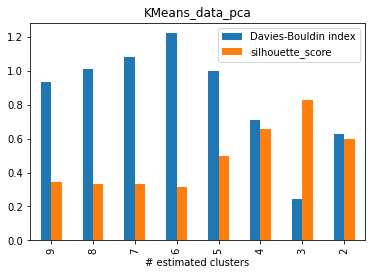

In [43]:
plot_proj_clustering(results[0], method='pca', suptitle='KMeans')